In [1]:
from IFD_tsne import *
#from utils import load_data, MidpointNormalize, equipotential_standard_normal, plot_heatmaps
from utils import MidpointNormalize, load_data
import seaborn as sns
import matplotlib.pyplot as plt
from tueplots import figsizes, fonts, bundles
from tueplots import cycler
from tueplots.constants import markers
from tueplots.constants.color import palettes
cmap = mpl.colors.LinearSegmentedColormap.from_list("", [palettes.tue_plot[0], "white", palettes.tue_plot[3]])
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})
plt.rcParams.update(cycler.cycler(color=palettes.tue_plot))
plt.rcParams.update({'figure.figsize': (2/3*5.511811263318113, 2/3*5.511811263318113)})
cmap = mpl.colors.LinearSegmentedColormap.from_list("", [palettes.tue_plot[0], "white", palettes.tue_plot[3]])

In [2]:
def KL_divergence(X_flat, Y_flat, X_unflattener, Y_unflattener):
    """
    (R^nxp x R^nxp)--> R
    """
    X = X_unflattener(X_flat)
    Y = Y_unflattener(Y_flat)
    learning_rate, perplexity = (200, 30.0)
    P = x2p(X, tol=1e-5, perplexity=perplexity)
    P = (P + np.transpose(P))
    P = P / np.sum(P)      # Why don't we devide by 2N as described everywhere?
    P = np.maximum(P, 1e-12)
    Q, _ = y2q(Y)
    return np.sum(P * (np.log(P+1e-10) - np.log(Q+1e-10)))

In [3]:
def compute_inverse_symmetric_matrix(X):
    L, lower = jax.scipy.linalg.cho_factor(X, lower=True)
    u = jax.scipy.linalg.solve_triangular(L, np.eye(np.shape(L)[0]), lower=True)
    L_t, lower = jax.scipy.linalg.cho_factor(X, lower=False)
    H_inv = jax.scipy.linalg.solve_triangular(L_t, u, lower=False)
    return H_inv

In [4]:
#X, y = make_blobs(n_samples=50, n_features=50, centers=4, random_state=0, shuffle=False, cluster_std=[0.1, 3, 3, 3])
X, y = load_data(50)
key = random.PRNGKey(42)
#X = onp.array(random.normal(key, shape=(50, 50)))
y_guess = random.normal(key, shape=(X.shape[0], 2))
#Y_star = TSNE(n_components=2, learning_rate=200, init=onp.array(y_guess), perplexity=30).fit_transform(X)
Y_star = tsne_fwd(X, y_guess)

X_flat, X_unflattener = flatten_util.ravel_pytree(X)   # row-wise
Y_flat, Y_unflattener = flatten_util.ravel_pytree(Y_star) 

I0000 00:00:1707126389.322018       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


===> Finding 49 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 0.9204, 50 iterations in 0.2737 sec
Iteration  100, KL divergence 0.8764, 50 iterations in 0.2553 sec
Iteration  150, KL divergence 0.8518, 50 iterations in 0.2604 sec
Iteration  200, KL divergence 1.0290, 50 iterations in 0.2579 sec
Iteration  250, KL divergence 0.9211, 50 iterations in 0.2589 sec
   --> Time elapsed: 1.31 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 750 iterations...
Iteration   50, KL divergence 0.1791, 50 iterations in 0.2518 sec
Iteration  100, KL divergence 0.1791, 50 iterations in 0.2560 sec
Iteration  150, KL divergence 0.1791, 50 iterations in 0.2574 sec
Iteration  200, KL divergence 0.1791, 50 iterations in 0.2543 sec
Iteration 

In [5]:
dy1, H1, J1 = d_y_star_d_x_outer(KL_divergence, X, Y_star)

Computing pairwise distances...
Starting binary search
Entered binary search function
Computing pairwise distances...
Starting binary search
Entered binary search function


In [6]:
def g(X_flat, Y_flat, X_unflattener, Y_unflattener, u, v):
    """
    (R^nxp x R^nxp)--> R
    """
    X = X_unflattener(X_flat)
    Y = Y_unflattener(Y_flat+u@v.T)
    learning_rate, perplexity = (200, 30.0)
    P = x2p(X, tol=1e-5, perplexity=perplexity)
    P = (P + np.transpose(P))
    P = P / np.sum(P)      # Why don't we devide by 2N as described everywhere?
    P = np.maximum(P, 1e-12)
    Q, _ = y2q(Y)
    return np.sum(P * (np.log(P+1e-10) - np.log(Q+1e-10)))

In [57]:
#v, w = np.linalg.eigh(H1)
#w_sorted = np.transpose(np.transpose(w)[np.flip(np.argsort(v))])
#v_sorted = np.flip(np.sort(np.abs(v)))
w, s, v = np.linalg.svd(H1)
w_sorted_sub = w[:, :97]
v_sorted_sub = v[:97, :]

In [65]:
print(w_sorted_sub)
print(v_sorted_sub)

[[-4.8206991e-01  3.3221852e-02 -3.5960036e-03 ...  3.8816277e-02
   6.1319161e-02 -6.5694764e-02]
 [-4.0957254e-01  5.2122813e-02  8.1305271e-03 ... -6.8228543e-02
   3.5452221e-02  1.3062829e-02]
 [ 1.5031099e-03 -5.8122324e-03  1.1739842e-02 ...  3.8796041e-02
  -1.2332908e-01  5.1062115e-02]
 ...
 [ 1.0462183e-02  8.5038036e-02  6.0445778e-03 ...  5.5716418e-02
  -3.6216870e-02  8.8413179e-02]
 [ 1.8213723e-03 -1.2746392e-02  2.6703095e-02 ...  3.7804931e-02
  -1.0463025e-01 -1.6514264e-02]
 [-8.5945185e-03  1.7430568e-02 -1.2431207e-01 ...  2.4707712e-02
   5.8561563e-05  1.8954590e-02]]
[[-4.82070029e-01 -4.09572721e-01  1.50305033e-03 ...  1.04621882e-02
   1.82137114e-03 -8.59452318e-03]
 [ 3.32220048e-02  5.21230474e-02 -5.81213646e-03 ...  8.50381628e-02
  -1.27464067e-02  1.74305383e-02]
 [-3.59606324e-03  8.13044235e-03  1.17398677e-02 ...  6.04441762e-03
   2.67030690e-02 -1.24311976e-01]
 ...
 [ 3.88161838e-02 -6.82285130e-02  3.87959220e-02 ...  5.57163991e-02
   3.78047

In [58]:
#w_sorted_sub = w_sorted[:, :97]
#w_sorted_sub = w_sorted
g_fun = lambda u: g(X_flat, Y_flat, X_unflattener, Y_unflattener, u, w_sorted_sub)

In [59]:
H_g = jax.hessian(g_fun)(np.zeros(w_sorted_sub.shape[1]))

Computing pairwise distances...
Starting binary search
Entered binary search function


In [60]:
H_g.shape

(97, 97)

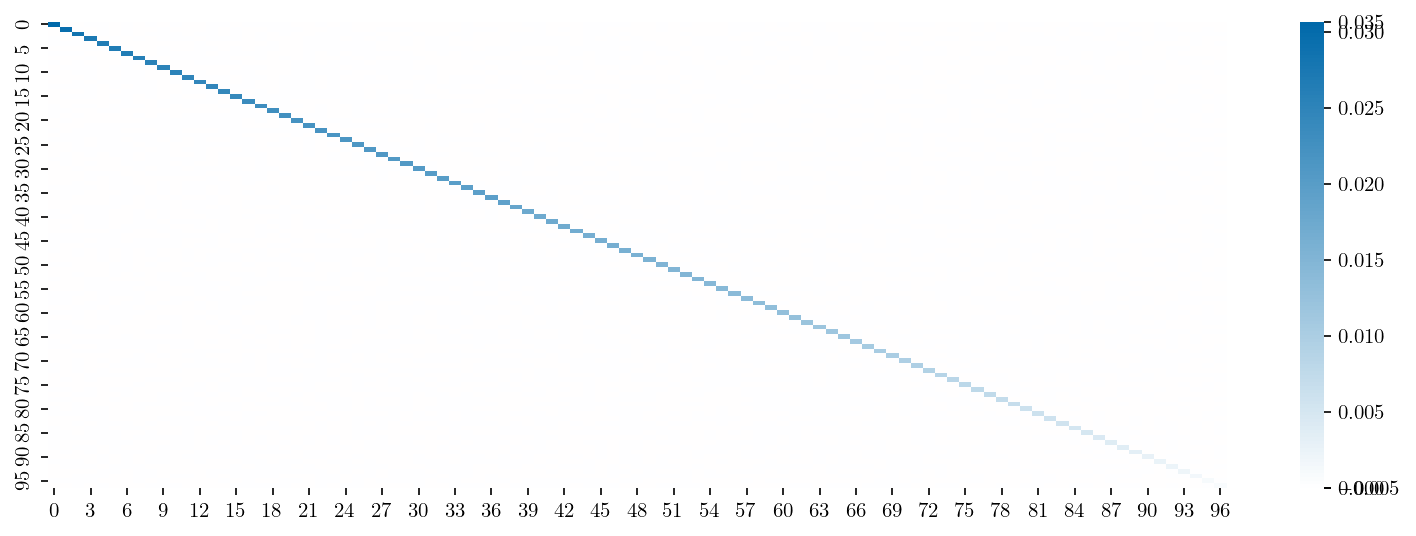

In [61]:
f, (ax1) = plt.subplots(1, 1)
sns.heatmap(H_g, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(H_g), vmax=np.max(H_g))), ax=ax1)
plt.tight_layout()
plt.savefig('tsne/GHessian.pdf')

In [40]:
print(s)

[3.06591392e-02 2.96968874e-02 2.84533445e-02 2.71576140e-02
 2.67032348e-02 2.66067404e-02 2.65000146e-02 2.60671712e-02
 2.55969781e-02 2.52827406e-02 2.52212957e-02 2.48097628e-02
 2.46196147e-02 2.44669877e-02 2.42807381e-02 2.39941012e-02
 2.35670581e-02 2.31891740e-02 2.27815304e-02 2.25949381e-02
 2.22522262e-02 2.21830197e-02 2.19523609e-02 2.17295587e-02
 2.14472804e-02 2.12422442e-02 2.09892001e-02 2.09260806e-02
 2.07859240e-02 2.06670426e-02 2.04972941e-02 2.01489180e-02
 2.00645402e-02 1.97945032e-02 1.96149107e-02 1.95776615e-02
 1.94782652e-02 1.90927777e-02 1.83228869e-02 1.76031571e-02
 1.74327213e-02 1.72847081e-02 1.71803217e-02 1.67948101e-02
 1.64962392e-02 1.63793173e-02 1.63055528e-02 1.61439087e-02
 1.59703810e-02 1.57424528e-02 1.52383028e-02 1.50572900e-02
 1.50008248e-02 1.49188349e-02 1.45639833e-02 1.42536061e-02
 1.39092663e-02 1.37727326e-02 1.35844145e-02 1.33324312e-02
 1.31790088e-02 1.27794789e-02 1.22051798e-02 1.17454976e-02
 1.16766514e-02 1.160208

In [41]:
print(np.diagonal(H_g))

[0.03064914 0.02968685 0.02844338 0.02714763 0.02669324 0.02659674
 0.02649001 0.02605716 0.02558697 0.02527274 0.02521129 0.02479976
 0.02460962 0.02445699 0.02427073 0.02398411 0.02355706 0.02317919
 0.02277152 0.02258493 0.02224224 0.02217302 0.02194235 0.02171958
 0.02143728 0.02123225 0.02097919 0.02091609 0.02077594 0.02065705
 0.02048728 0.02013892 0.02005455 0.0197845  0.01960492 0.01956767
 0.01946827 0.01908279 0.0183129  0.01759317 0.01742273 0.01727472
 0.01717033 0.01678482 0.01648624 0.01636931 0.01629556 0.01613391
 0.01596038 0.01573244 0.01522831 0.01504729 0.01499082 0.01490884
 0.01455399 0.01424361 0.01389927 0.01376273 0.01357441 0.01332243
 0.013169   0.01276948 0.01219518 0.0117355  0.01166665 0.01159208
 0.01090016 0.01059065 0.01044159 0.01010387 0.00979256 0.00959132
 0.00928921 0.00874237 0.00832491 0.00793352 0.00777452 0.00755065
 0.00705573 0.00671174 0.00619267 0.00599159 0.00587115 0.0056158
 0.00514269 0.00486086 0.00439142 0.0040306  0.00360694 0.00327

In [12]:
H_g_inv = compute_inverse_symmetric_matrix(H_g)

<Axes: >

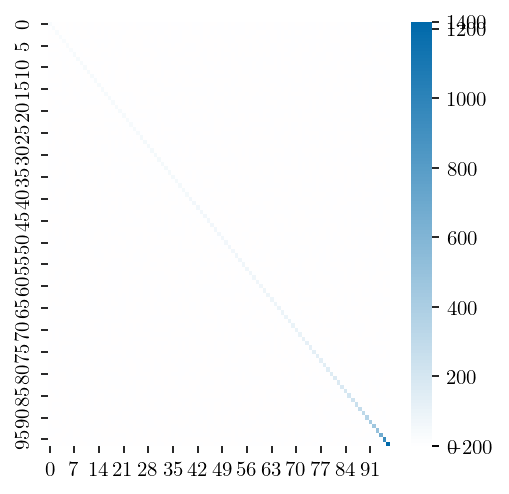

In [13]:
f, (ax1) = plt.subplots(1, 1)
sns.heatmap(H_g_inv, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(H_g_inv), vmax=np.max(H_g_inv))), ax=ax1)

In [14]:
J_g_mixed = jacfwd(jacfwd(g, argnums=4), argnums=0)(X_flat, Y_flat, X_unflattener, Y_unflattener, np.zeros(w_sorted_sub.shape[1]), w_sorted_sub)

Computing pairwise distances...
Starting binary search
Entered binary search function


In [15]:
J_g_mixed.shape

(97, 2500)

<Axes: >

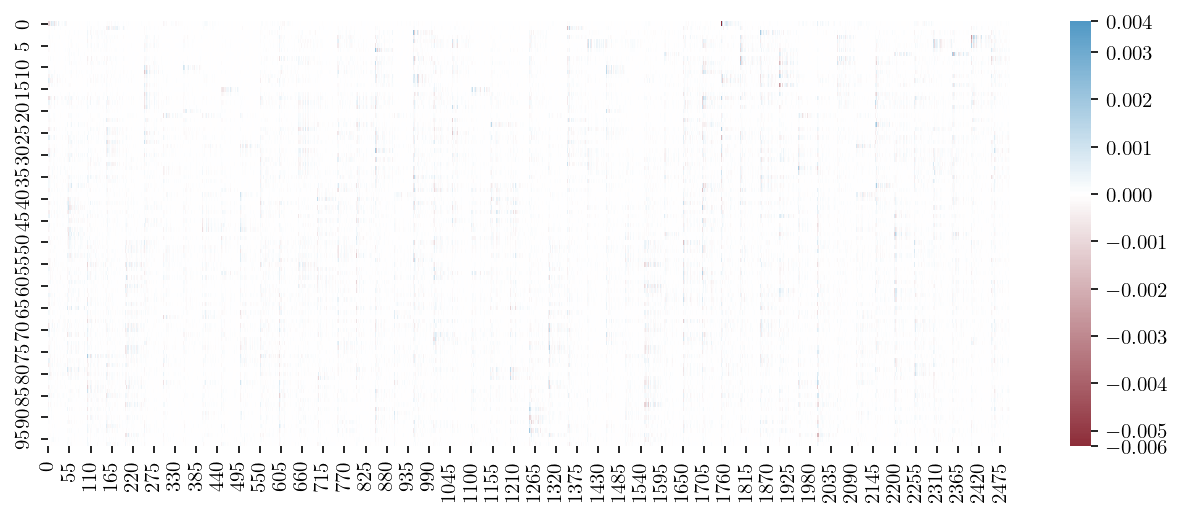

In [42]:
f, (ax1) = plt.subplots(1, 1)
sns.heatmap(J_g_mixed, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(J_g_mixed), vmax=np.max(J_g_mixed))), ax=ax1)

<Axes: >

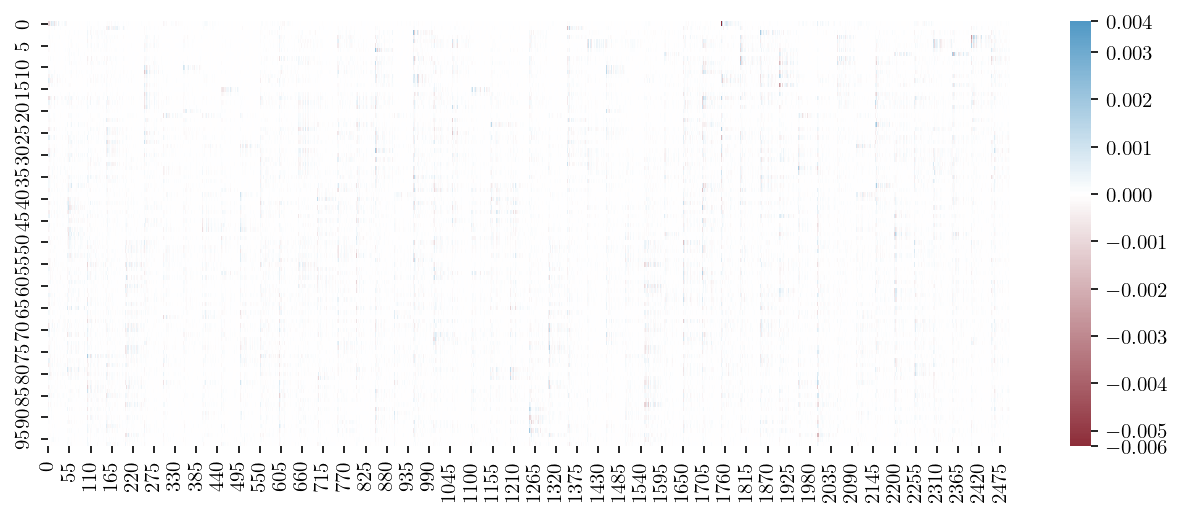

In [64]:
J_test = np.transpose(w_sorted_sub) @ J1
f, (ax1) = plt.subplots(1, 1)
sns.heatmap(J_test, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(J_test), vmax=np.max(J_test))), ax=ax1)

<Axes: >

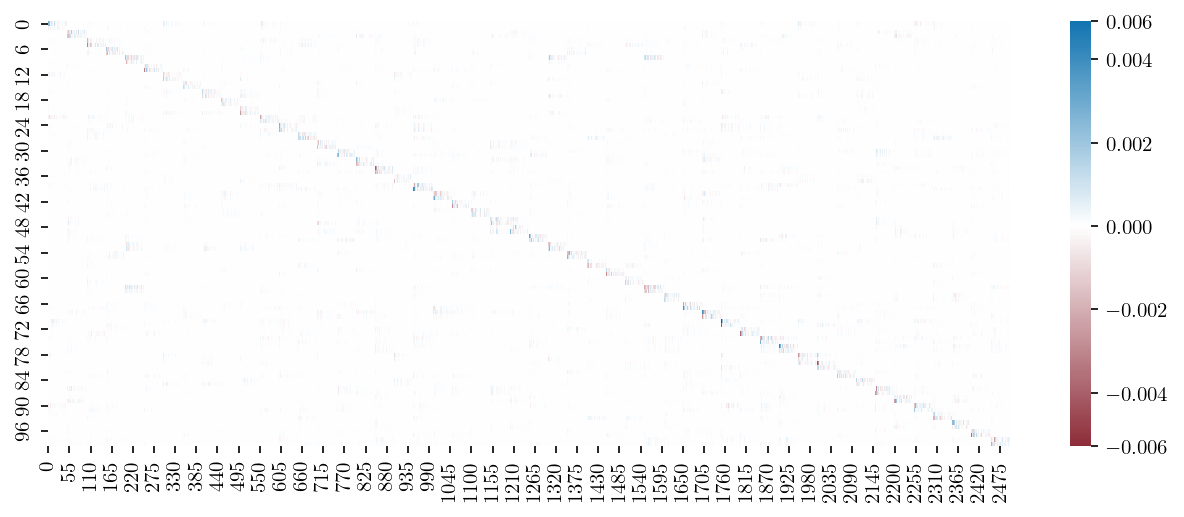

In [43]:
f, (ax1) = plt.subplots(1, 1)
sns.heatmap(J1, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(J1), vmax=np.max(J1))), ax=ax1)

In [16]:
du_dx = -H_g_inv @ J_g_mixed

In [17]:
du_dx.shape

(97, 2500)

In [35]:
dy_dx = w_sorted_sub @ du_dx

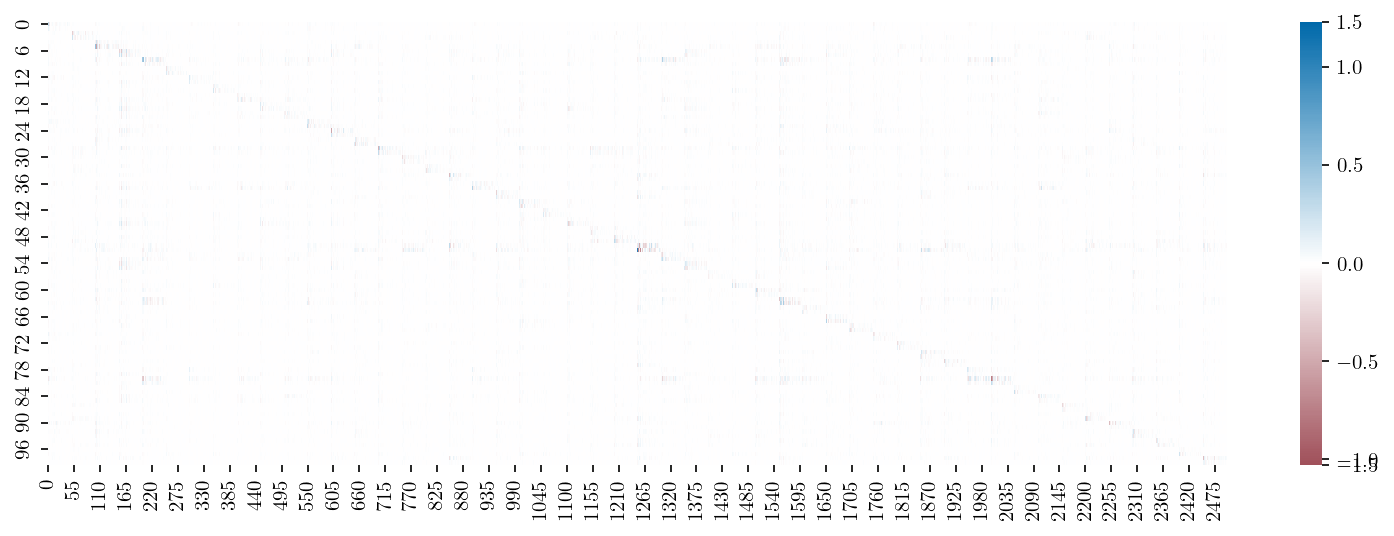

In [36]:
plt.rcParams.update({'figure.figsize': (2/3*15.511811263318113, 2/3*5.511811263318113)})
f, (ax1) = plt.subplots(1, 1)
sns.heatmap(dy_dx, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(dy_dx), vmax=np.max(dy_dx))), ax=ax1)
plt.tight_layout()
plt.savefig('tsne/dydx_idea.pdf')


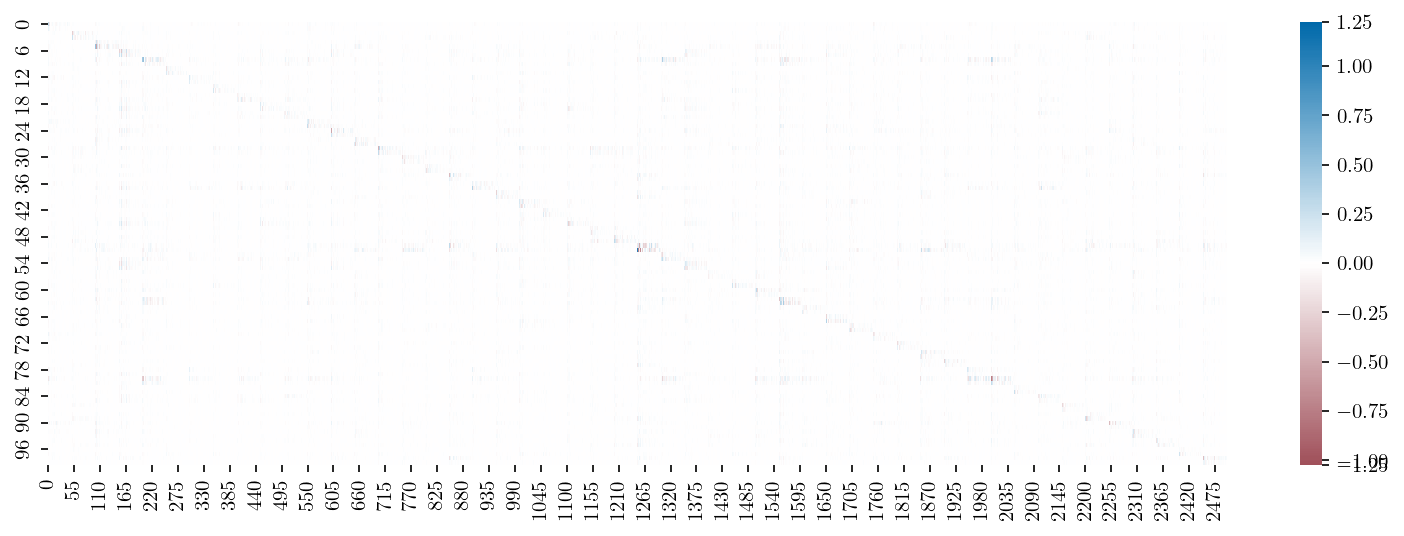

In [20]:
f, (ax1) = plt.subplots(1, 1)
sns.heatmap(dy1, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(dy1), vmax=np.max(dy1))), ax=ax1)
plt.tight_layout()
plt.savefig('tsne/dydx_direct.pdf')

In [67]:
H_pinv = np.linalg.pinv(H1)

<Axes: >

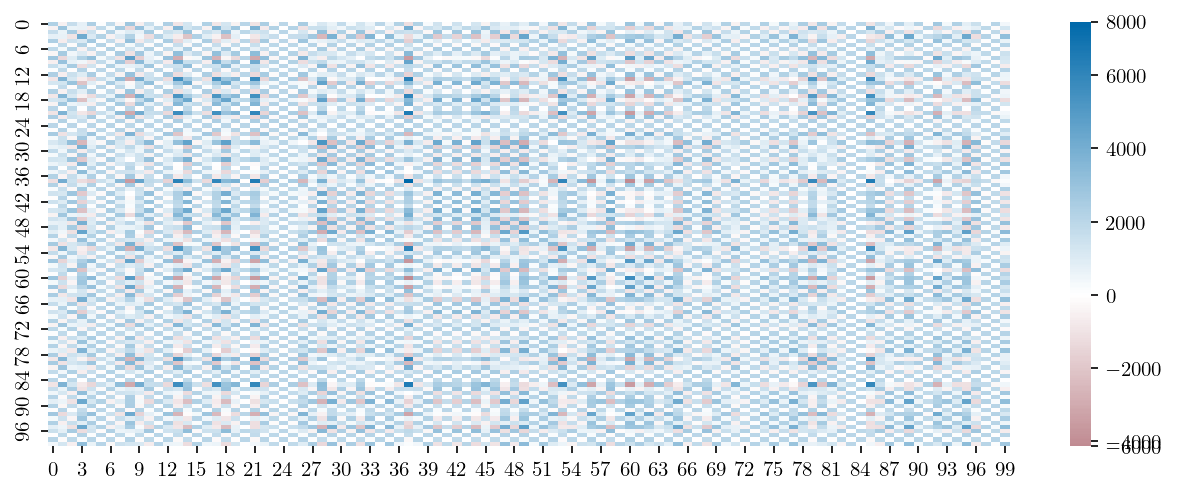

In [68]:
f, (ax1) = plt.subplots(1, 1)
sns.heatmap(H_pinv, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(H_pinv), vmax=np.max(H_pinv))), ax=ax1)

In [69]:
dy_pinv = -H_pinv @ J1

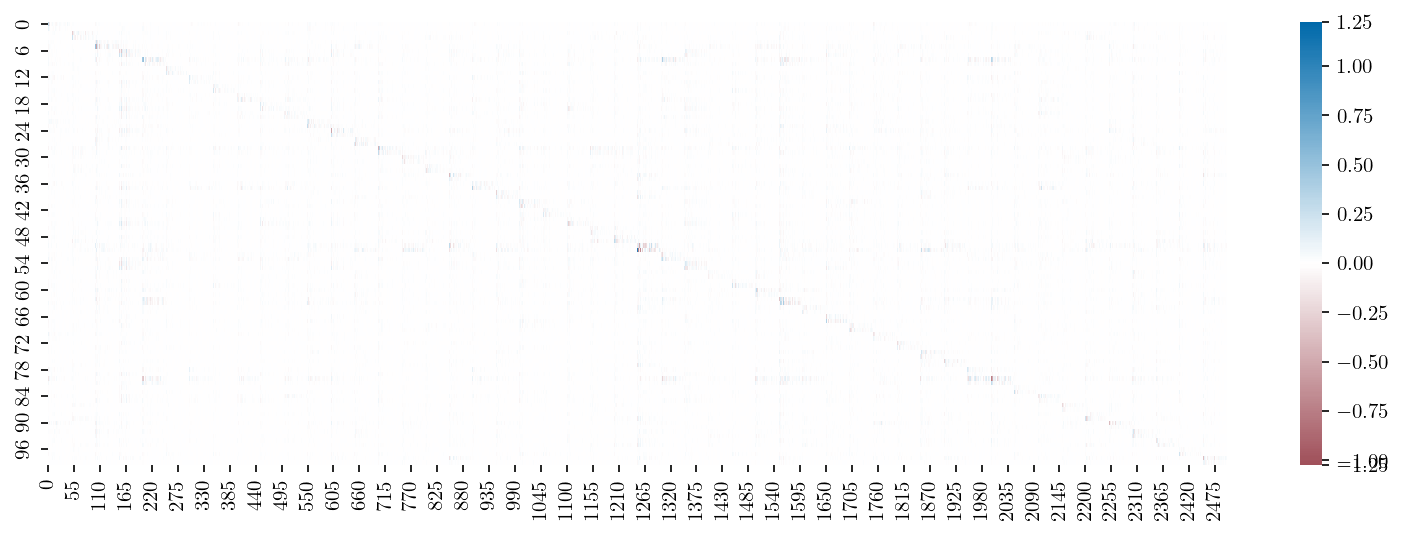

In [71]:
f, (ax1) = plt.subplots(1, 1)
sns.heatmap(dy_pinv, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(dy_pinv), vmax=np.max(dy_pinv))), ax=ax1)
plt.tight_layout()
plt.savefig('tsne/dydx_pinv.pdf')


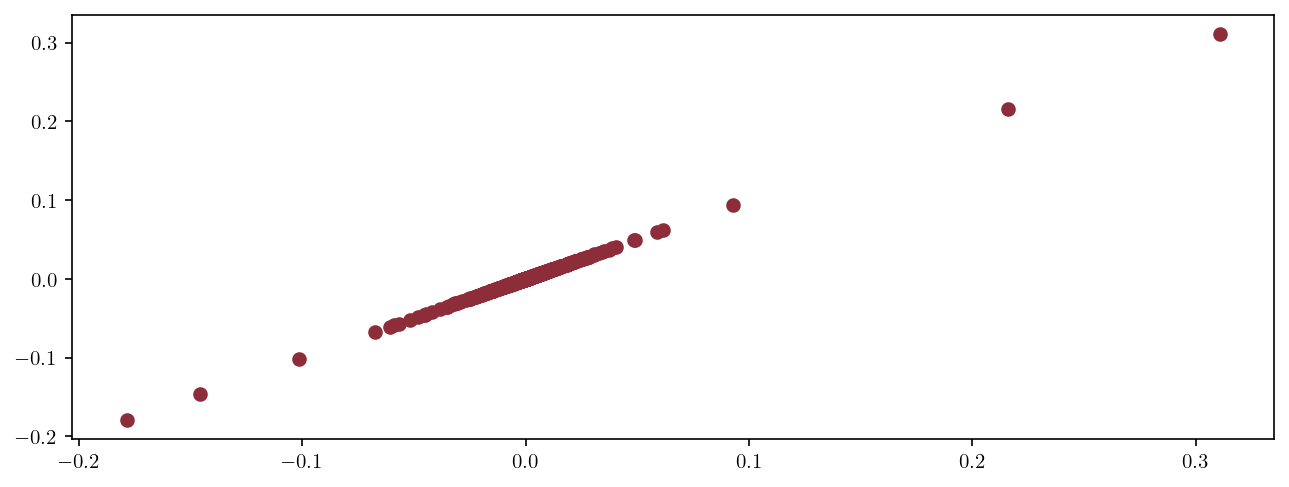

In [74]:
plt.scatter(dy_pinv[0], dy_dx[0])